In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import joblib 

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import *

# Corpus Processing
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
# loading dataset
reviews = pd.read_csv("annotated_data_sentiment.csv", encoding='utf-8')
reviews.head(5)

,index,created_at,custom_comment,sentiment
0,30,01/03/2023 22:06,Great guy!!!,1
1,33,02/03/2023 06:46,he is the best driver,1
2,45,02/03/2023 14:15,The best driver!),1
3,52,02/03/2023 17:11,Perfect. Recommend,1
4,53,02/03/2023 17:41,Perfect trip,1


#### Exploring the data distribution

In [7]:
reviews['sentiment'].value_counts()

-1    3749
 1    1408
Name: sentiment, dtype: int64

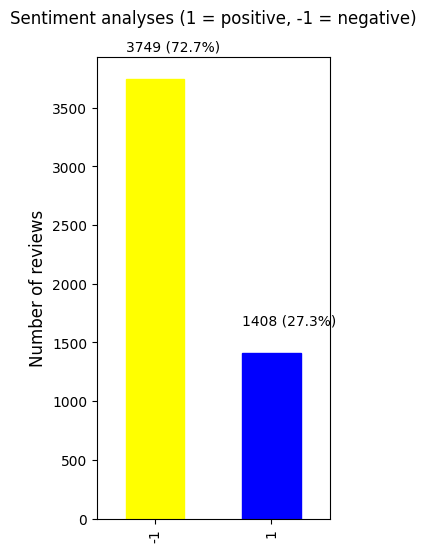

In [4]:
ax = reviews['sentiment'].value_counts().plot(kind='bar', figsize=(3, 6), fontsize=10)
ax.set_title('Sentiment analyses (1 = positive, -1 = negative)', size=12, pad=24)
ax.set_ylabel('Number of reviews', fontsize=12)

N = len(reviews)
colors= ['yellow','blue']
idx = 0
for i in ax.patches:
    ax.text(i.get_x(), i.get_height() + 240, f"{str(round(i.get_height(), 2))} ({round(i.get_height()*100/N, 2)}%)", fontsize=10)
    i.set_color(colors[idx])
    idx+=1

#### data cleaning & preprocessing:

In [5]:
stopwords = ['a', 'about', 'an', 'am' 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you']

short_forms = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "couldn't": "could not",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    # Add more short forms and their full forms as needed
}

def replace_short_forms(text):
    # Create a regular expression pattern to match short forms as standalone words
    pattern = r'\b(?:{})\b'.format('|'.join(short_forms.keys()), re.IGNORECASE)
    
    # Replace short forms with their corresponding full forms using a lambda function
    full_forms_text = re.sub(pattern, lambda match: short_forms[match.group(0)], text)
    
    return full_forms_text


# (?) remove quotation marks, unnecessary punctuation, [{}[]\/+*%|^%#@!?()]
def punctuation_remover(text):
    pattern = r'[{}\[\]\\\/\+\*%\|\^%#@\(\)\$\"]'
    return re.sub(pattern, ' ', text)


def lemma_stopwords_token(text):
      le=WordNetLemmatizer()
      word_tokens=nltk.word_tokenize(text)
      word_tokens =[token for token in word_tokens if token.isalpha()]
      tokens=[le.lemmatize(token) for token in word_tokens if token not in stopwords and len(token)>2]
      processed_text =" ".join(tokens)
      return processed_text


# main preprocessing function
def preprocessing(text):
    reviews = replace_short_forms(text)
    reviews = punctuation_remover(reviews)
    reviews = lemma_stopwords_token(reviews)
    return reviews

#### data split

In [8]:
# download reviews from dataset and preprocess them into a list
data = [preprocessing(custom_comment) for custom_comment in reviews['custom_comment'].to_list()]

# download label into a list
label = [label for label in reviews['sentiment'].to_list()]

In [11]:
print(data)

['Great guy', 'best driver', 'The best driver', 'Perfect Recommend', 'Perfect trip', 'thanks recommend', 'best driver well experienced and help full deserve promtion and best driver year', 'Thanks lot bro', 'Cool music', 'great service', 'Great guy and really deserves star rating', 'gentleman speaks English fluently and render great service', 'one best driver travelled Kyiv', 'amazing best driver', 'ease and good very great service', 'Clean avto polite driver great service', 'Friendly driver one best experience taxi', 'Great left change Great service', 'perfect fast and safe', 'One best service time here Thanks', 'The best guy Utaxi Such nice person', 'Very smart and positive driver The best Odessa', 'pretty nice ride', 'recommend service', 'car very smelly almost threw not think cleaned driver showered', 'good servise', 'Great thanks', 'one best driver', 'The best driver and person', 'Great Service', 'Thanks lot', 'Great service Thank Andriy', 'great service thank', 'The best driver U

In [9]:
# Extract features from the preprocessed data and fit it
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

#### fit & train the model,  run predictions and analyze the results 

In [10]:
clf_Naive_Bayes = MultinomialNB()
clf_Naive_Bayes.fit(X_train, y_train)

# Form a prediction set
prediction = clf_Naive_Bayes.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))


[[739   4]
 [ 63 226]]
              precision    recall  f1-score   support

          -1       0.92      0.99      0.96       743
           1       0.98      0.78      0.87       289

    accuracy                           0.94      1032
   macro avg       0.95      0.89      0.91      1032
weighted avg       0.94      0.94      0.93      1032

0.935077519379845


In [9]:
# # Save the trained model for later use
joblib.dump(clf_Naive_Bayes, 'model_sentiment_Naive_Bayes.joblib')

['model_sentiment_Naive_Bayes.joblib']

In [10]:
# Fit the Linear SVC model on the training set
from sklearn.svm import LinearSVC

clf_LinearSVC = LinearSVC(max_iter=5000)
clf_LinearSVC.fit(X_train, y_train)
y_pred = clf_LinearSVC.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print a classification report
print(metrics.classification_report(y_test,y_pred))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, y_pred))

[[738   5]
 [ 42 247]]
              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       743
           1       0.98      0.85      0.91       289

    accuracy                           0.95      1032
   macro avg       0.96      0.92      0.94      1032
weighted avg       0.96      0.95      0.95      1032

0.9544573643410853


In [12]:
# Save the trained model for later use
joblib.dump(clf_LinearSVC, 'model_sentiment_LinearSVC.joblib')

['model_sentiment_LinearSVC.joblib']

#### adding SMOTE Technique *(Synthetic Minority Oversampling Technique)*

In [ ]:
# !pip install imbalanced-learn

*What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the neighbors an generates random points on the lines.*

In [13]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({-1: 3006, 1: 1119})
After Counter({-1: 3006, 1: 3006})


In [14]:
# Naïve Bayes - SMOTE Resampling:

clf_Naive_Bayes_SMOTE = MultinomialNB()
clf_Naive_Bayes_SMOTE.fit(X_train_sm, y_train_sm)

# Form a prediction set
prediction = clf_Naive_Bayes_SMOTE.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))

[[712  31]
 [ 35 254]]
              precision    recall  f1-score   support

          -1       0.95      0.96      0.96       743
           1       0.89      0.88      0.89       289

    accuracy                           0.94      1032
   macro avg       0.92      0.92      0.92      1032
weighted avg       0.94      0.94      0.94      1032

0.936046511627907


In [15]:
# Save the trained model for later use
joblib.dump(clf_Naive_Bayes_SMOTE, 'model_sentiment_Naive_Bayes_SMOTE.joblib')

['model_sentiment_Naive_Bayes_SMOTE.joblib']

In [16]:
# LinearSVC(max_iter=5000) - SMOTE Resampling:

clf_LinearSVC_SMOTE = LinearSVC(max_iter=5000)
clf_LinearSVC_SMOTE.fit(X_train_sm, y_train_sm)

# Form a prediction set
prediction = clf_LinearSVC_SMOTE.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))

[[723  20]
 [ 30 259]]
              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       743
           1       0.93      0.90      0.91       289

    accuracy                           0.95      1032
   macro avg       0.94      0.93      0.94      1032
weighted avg       0.95      0.95      0.95      1032

0.9515503875968992


In [17]:
# Save the trained model for later use
joblib.dump(clf_LinearSVC_SMOTE, 'model_sentiment_LinearSVC_SMOTE.joblib')

['model_sentiment_LinearSVC_SMOTE.joblib']

#### testing the model

In [18]:
def prepare_new_reviews(text):
  """
  Prepare new text for model testing: preprocess it, vectorize, predict label and return it
  """
  
  preprocessed_text = preprocessing(text)
  features = vectorizer.transform([preprocessed_text])
  loaded_model = joblib.load('model_sentiment_Naive_Bayes_SMOTE.joblib')
  prediction = loaded_model.predict(features)
  # return prediction[0]

  if prediction[0] == 1:
    return "Sentiment: positive"
  else:
    return "Sentiment: negative"


# in this list you can indicate which news to classify
reviews_example = ["the ride was pretty nice",
                """The drivers behaviour is inappropriate""",
                """I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??""",
                """reckless driver!""",
                """Nice driver, really helpful""",
                """vehicle of premium class""",
                """Great experience.I'd recommend this service to my friends.""",
                "smooth ride",
                "it took longer time, but the driver was good"]

for i,review in enumerate(reviews_example):
  print(f"{i}. {review}")
  print(f"{prepare_new_reviews(review)}")
  

0. the ride was pretty nice
Sentiment: positive
1. The drivers behaviour is inappropriate
Sentiment: negative
2. I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??
Sentiment: negative
3. reckless driver!
Sentiment: negative
4. Nice driver, really helpful
Sentiment: positive
5. vehicle of premium class
Sentiment: positive
6. Great experience.I'd recommend this service to my friends.
Sentiment: positive
7. smooth ride
Sentiment: positive
8. it took longer time, but the driver was good
Sentiment: negative


#### DL, applying CNN

In [47]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer


In [34]:
data = [preprocessing(custom_comment) for custom_comment in reviews['custom_comment'].to_list()]
label = reviews['sentiment'].values.tolist()

##### prepare data

In [52]:
# tokenize the words in the texts

max_words = 20000 #max number of words in the texts to be vectorized (choose the frequent words)

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(data) 
# convert each review text into a sequence of word-indices
data_seq = tokenizer.texts_to_sequences(data)


# pad each review text to a fixed length of word sequence
maxlen = 1000  # maximum length of each review
data_pad = pad_sequences(data_seq, maxlen=maxlen)

# convert to numpy arrays 
data = np.array(data_pad)
label = np.array(label)

In [57]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_pad, label, test_size=0.2, random_state=42)


#### define CNN

In [58]:
inputs = Input(shape=(maxlen,))
embedding = Embedding(max_words, 128, input_length=maxlen)(inputs)

# Apply multiple 1D convolutional layers with different kernel sizes
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)
pool1 = GlobalMaxPooling1D()(conv1)

conv2 = Conv1D(filters=64, kernel_size=4, activation='relu')(embedding)
pool2 = GlobalMaxPooling1D()(conv2)

conv3 = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding)
pool3 = GlobalMaxPooling1D()(conv3)

# Concatenate the output of the pooling layers
merged = tf.concat([pool1, pool2, pool3], axis=-1)

flatten = Flatten()(merged)
dense = Dense(64, activation='relu')(flatten)
outputs = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1000, 128)    2560000     ['input_11[0][0]']               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 998, 64)      24640       ['embedding_10[0][0]']           
                                                                                                  
 conv1d_31 (Conv1D)             (None, 997, 64)      32832       ['embedding_10[0][0]']           
                                                                                            

In [ ]:
# # layer 0: the input layer
# inputs = Input(shape=(maxlen,))
# # layer-1: the embedding layer
# embedding = Embedding(max_words, 128, input_length=maxlen)(inputs)

# # Apply multiple 1D convolutional layers with different kernel sizes

# # layer-2: the first convolution layer
# x = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)
# # layer-3: the first pooling layer
# x = MaxPooling1D(pool_size=2)(x)

# # layer-4: the second convolution layer
# x = Conv1D(filters=64, kernel_size=4, activation='relu')(x)
# # layer-5: the second pooling layer
# x = MaxPooling1D(pool_size=2)(x)

# # layer-6: the third convolution layer
# x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
# # layer-7: the third pooling layer
# x = MaxPooling1D(pool_size=2)(x)

# # flatten layer
# x = Flatten()(x)

# # layer-8: the first dense layer
# x = Dense(64, activation='relu')(x)

# # layer-9: the output layer
# outputs = Dense(1, activation='sigmoid')(x)

# # define the model
# model = Model(inputs=inputs, outputs=outputs)
# model.summary()

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.1, shuffle=True, epochs=5, batch_size=128)

In [60]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

33/33 [==============================] - 2s 59ms/step - loss: -7081.3555 - accuracy: 0.0000e+00
Test Accuracy: 0.00%
